In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Load relevant data**

In [2]:
# Translation table
translation_df = pd.read_csv('data/external/candSID_PanAfID_translations_old_platform_2021_11_27.csv')
translation_df['video'] = translation_df['clip.id'].str.lower()
translation_df['video_id'] = translation_df['video.id'].str.lower()
translation_df['new_file_name'] = translation_df['new.file.name'].str.lower()
translation_df.drop(columns=['Unnamed: 0', 'clip.id', 'video.id', 'new.file.name'], inplace=True)

In [3]:
# ACP prefixed videos
acp_df = pd.read_csv('data/internal/acp_prefixed_videos.csv', names=['video'], header=None)
acp_df.video = acp_df.video.str.split('.').str[0].str.lower()

In [6]:
acp_df.video.str.upper()

NaN                 0
0.0        ACP000CAPQ
1.0        ACP000FW7F
2.0        ACP000CFOZ
3.0        ACP00055T9
              ...    
19971.0    ACP000DSR0
19972.0    ACP00083QH
19973.0    ACP000DRQ3
19974.0    ACP00072MR
19975.0    ACP00027EH
Name: video, Length: 19977, dtype: object

In [7]:
acp_df['uppercase'] = acp_df.video.str.upper()

In [12]:
acp_df.to_csv('acp_videos.csv', index=False)

In [45]:
# Maureens annotations
csv_files = glob('/home/dl18206/Desktop/phd/data/panaf/maureen_annotations/data/sites/csv/**/*.csv', recursive=True)
sorted_csv_files = sorted(csv_files, key=lambda x: x.split('/')[-1])
initialiser, remainder = sorted_csv_files[0], sorted_csv_files[1:]
df = pd.read_csv(initialiser, encoding="ISO-8859-1")
for file in remainder:
    site = pd.read_csv(file, encoding="ISO-8859-1")
    df = pd.concat([df, site])
df['subdir_video'] = df.subfolder.astype(str) + '_' + df.video_file_name.astype(str)
df['subdir_video'] = df.subdir_video.str.lower()
df['subdir_video'] = df.subdir_video.str.split('.').str[0]

In [46]:
print(f'Unique videos translation table: {translation_df.video.unique().__len__()}')
print(f'Unique videos translation table: {acp_df.video.unique().__len__() }')

Unique videos translation table: 562805
Unique videos translation table: 19977


**Merge acp-prefixed and translation dataframes**

In [47]:
acp_trans_df = acp_df.merge(translation_df, on='video')
# Create subdir_video column to allow downstream merging with 
acp_trans_df['subdir_video'] = acp_trans_df.new_file_name.apply(lambda x: '_'.join(x.split('/')[-2:]))
acp_trans_df['subdir_video'] = acp_trans_df.subdir_video.apply(lambda x: x.split('.')[0])
acp_trans_df.drop(columns=['video_id', 'new_file_name'], inplace=True)

**Chimp & See annotations**

In [48]:
# Read chimp and see annotations and merge with acp-prefixed and translation dataframes
chimp_df = pd.read_excel('data/internal/Chimp & See master chimpanzee video list 2015-2018_OB_analysis.xlsx', sheet_name="Otto's Analysis (Plain Text)")
chimp_df['video'] = chimp_df.ID.str.lower()
all_df = acp_trans_df.merge(chimp_df, on='video')

# Convert tags to list of tokens
all_df['split_tags'] = all_df.Tags.str.split(' ')

In [49]:
# Import unique tag analysis
tag_df = pd.read_excel('/home/dl18206/Downloads/unique_tags 1.xlsx', sheet_name='all')

attr = tag_df.columns[1:]
for col in tag_df.columns[1:]:
    unique_tags = tag_df[tag_df[col]==col].tags.unique()
    all_df[col] = all_df.split_tags.apply(lambda x: 1 if any(i in x for i in unique_tags) else 0)
    
# Create column indicating empties
all_df['label_indicator'] = all_df[tag_df.columns[1:]].astype(int).apply(lambda x: True if any([i for i in x]) else False, axis=1)

In [52]:
all_df.columns

Index(['video', 'site', 'subdir_video', 'ID', 'Tags', 'Unnamed: 2',
       'split_tags', 'camera_reaction_main', 'camera_reaction_attraction',
       'camera_reaction_notes', 'off_camera', 'tool_use', 'tool_carry',
       'termite_fishing', 'nut_cracking', 'tool_use_surface', 'tool_use_mound',
       'stone_throw', 'honey_pound', 'swelling', 'selfie', 'bipedal',
       'night_chimps', 'feeding', 'wood_eating', 'chimp_carrying',
       'vocalisation', 'running', 'walking', 'climbing', 'standing',
       'aggression', 'charge', 'travel', 'fight', 'branch_shaking', 'hoot',
       'grunt', 'sex', 'water', 'drinking', 'piloerection',
       'social_interaction', 'defecating', 'display', 'grooming', 'smelling',
       'label_indicator'],
      dtype='object')

In [60]:
all_df[(all_df.grooming==1)]

,video,site,subdir_video,ID,Tags,Unnamed: 2,split_tags,camera_reaction_main,camera_reaction_attraction,camera_reaction_notes,...,sex,water,drinking,piloerection,social_interaction,defecating,display,grooming,smelling,label_indicator
432,acp000cn3u,bwindi,bwi_vid22_805001_9884029_20121011_pict0136,ACP000cn3u,grooming chimp 3_chimp needcid victor chimps r...,RS13,"[grooming, chimp, 3_chimp, needcid, victor, ch...",0,0,0,...,0,0,0,0,0,0,0,1,0,True
445,acp000f6m8,taieast,taieast_19_0690226_0643742_20141206+_ek000075,ACP000f6m8,grooming 3_chimp marlyn filou kamala agedviole...,AV15,"[grooming, 3_chimp, marlyn, filou, kamala, age...",0,0,0,...,0,0,0,0,0,0,0,1,0,True
717,acp000emlr,taieast,taieast_71_0689498_0642772_20150124+_ek000022,ACP000emlr,6_chimp avfem11 grooming taiga infant agedviol...,AV15,"[6_chimp, avfem11, grooming, taiga, infant, ag...",0,0,0,...,0,0,0,0,0,0,0,1,0,True
747,acp000bi0v,bwindi,bwi_vid13_806023_9883895_20130322_pict0497,ACP000bi0v,restlessstar grooming caesar-herbert lesley ma...,RS13,"[restlessstar, grooming, caesar-herbert, lesle...",0,0,0,...,0,0,0,0,0,0,0,1,0,True
779,acp000bgby,bwindi,bwi_vid20_804009_9883189_20121013_pict0297,ACP000bgby,wadging 2_chimp restlessstar grooming chimp,RS13,"[wadging, 2_chimp, restlessstar, grooming, chimp]",0,0,0,...,0,0,0,0,0,0,0,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13419,acp000509v,east_nimba,nim_vid23_0548309_0822019_20131120_ek000055,ACP000509v,crimsondew 2_chimp grooming luigi chimp fry ch...,CD8,"[crimsondew, 2_chimp, grooming, luigi, chimp, ...",0,0,0,...,0,0,0,0,0,0,0,1,0,True
13675,acp000bj7z,bwindi,bwi_vid7_806110_9885227_20120911_pict0139,ACP000bj7z,5_chimp restlessstar chimp needcid rsjuv21 chi...,RS13,"[5_chimp, restlessstar, chimp, needcid, rsjuv2...",1,0,0,...,0,0,0,0,0,0,0,1,0,True
14005,acp000d0z8,ngogo,ngo_vid15_0217159_0054492_20130416_pict0132,ACP000d0z8,cassini chimp male bohr adult vocalization gre...,GS16,"[cassini, chimp, male, bohr, adult, vocalizati...",0,0,0,...,0,0,0,0,0,0,0,1,0,True
14120,acp000drrt,ngogo,ngo_vid03_0216558_0056315_20121201_pict0125,ACP000drrt,gsinf11 gsjuv08d gsfem17d 4_chimp 5_chimp jemi...,GS16,"[gsinf11, gsjuv08d, gsfem17d, 4_chimp, 5_chimp...",0,0,0,...,0,0,0,0,0,0,0,1,0,True


In [9]:
# Multi-class label conversion
# Define a lambda function to convert binary columns to a multiclass label
to_label = lambda x: ','.join([str(i) for i in x])

# Apply the lambda function to each row to create a new column 'label'
all_df['label'] = all_df[tag_df.columns[1:]].astype(int).apply(to_label, axis=1).astype('category')
all_df['label'] = all_df.label.str.split(',')
all_df['label'] = all_df.label.apply(lambda x: [int(i) for i in x])

# print output
# all_df.label.value_counts()

**Investigate videos without any behavioural annotation**

In [10]:
acp_trans_panaf_df = acp_trans_df.merge(df, on='subdir_video')
acp_trans_panaf_df.columns

Index(['video', 'site', 'subdir_video', 'new_row_id', 'country',
       'research_site', 'genus', 'species', 'cam_coverage_area',
       'location_metadata', 'habitat', 'utm_zone', 'utm_long', 'utm_lat',
       'cam_id', 'vid_res', 'vid_duration', 'panaf_datasheet_comments', 'year',
       'month', 'day', 'time_hr', 'time_min', 'cell_id', 'subfolder',
       'video_file_name', 'event_id', 'min_number_chimps_per_video',
       'max_number_chimps_per_video', 'age_class', 'sex', 'tool_use',
       'vocalization', 'bipedal', 'camera_reaction', 'behavioral_context',
       'other_species', 'additional_comments', 'record_type'],
      dtype='object')

In [12]:
# Filter ONLY videos which have 0 behavioural annotation
no_annotations = all_df['video']
acp_trans_df = acp_trans_df[acp_trans_df.video.isin(no_annotations)]

In [13]:
# Merging PanAf annotations with new platform
acp_trans_panaf_df = acp_trans_df.merge(df, on='subdir_video')

In [14]:
(acp_trans_panaf_df.behavioral_context.value_counts() / acp_trans_panaf_df.behavioral_context.value_counts().sum()) * 100

feeding                    39.321066
travel                     35.017687
climbing                    6.678999
tool use nuts               4.011294
tool use                    3.926914
resting                     3.612112
unclear                     2.073800
camera reaction             2.034855
displaying                  1.132639
playing                     0.850290
grooming                    0.584169
aggression                  0.405673
sexual                      0.168760
tool use termites           0.064908
greeting                    0.051926
reassurance                 0.038945
tool use stone throwing     0.022718
no                          0.003245
Name: behavioral_context, dtype: float64

In [15]:
# Remove all columns except video_id and behavioural context
acp_trans_panaf_df.drop(acp_trans_panaf_df.columns.difference(['video', 'behavioral_context', 'tool_use','vocalization', 'bipedal', 'camera_reaction']), 1, inplace=True)
acp_trans_panaf_df.fillna('no', inplace=True)

# Convert behavioural context to multiple columns with binary indicators
behavioural_context_df = pd.get_dummies(acp_trans_panaf_df, columns=['behavioral_context'])
behavioural_context_df.replace({'yes': 1, 'off_camera':1, 'offscreen':1, 'no': 0}, inplace=True)

# Unify labels for multiple sub classes
behavioural_context_df['true_tool_use']=(behavioural_context_df.tool_use==1)|(behavioural_context_df['behavioral_context_tool use']==1)|(behavioural_context_df['behavioral_context_tool use nuts']==1)
behavioural_context_df['true_camera_reaction']=(behavioural_context_df['camera_reaction']==1)|(behavioural_context_df['behavioral_context_camera reaction']==1)
behavioural_context_df['true_tool_use'] = behavioural_context_df['true_tool_use'].astype(int)
behavioural_context_df['true_camera_reaction'] = behavioural_context_df['true_camera_reaction'].astype(int)

<ipython-input-15-216357687b0b>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  acp_trans_panaf_df.drop(acp_trans_panaf_df.columns.difference(['video', 'behavioral_context', 'tool_use','vocalization', 'bipedal', 'camera_reaction']), 1, inplace=True)


In [16]:
behavioural_context_df.drop(columns=['tool_use', 'camera_reaction', 'behavioral_context_camera reaction', 'behavioral_context_greeting', 'behavioral_context_resting', 'behavioral_context_tool use', 'behavioral_context_tool use nuts', 'behavioral_context_unclear'], inplace=True)

In [17]:
behavioural_context_df.columns

Index(['video', 'vocalization', 'bipedal', 'behavioral_context_aggression',
       'behavioral_context_climbing', 'behavioral_context_displaying',
       'behavioral_context_feeding', 'behavioral_context_grooming',
       'behavioral_context_no', 'behavioral_context_playing',
       'behavioral_context_reassurance', 'behavioral_context_sexual',
       'behavioral_context_tool use stone throwing',
       'behavioral_context_tool use termites', 'behavioral_context_travel',
       'true_tool_use', 'true_camera_reaction'],
      dtype='object')

In [18]:
behavioural_context_df.rename(
    columns={
    "vocalization": "vocalisation", 
    "behavioral_context_aggression": "aggression", 
    "behavioral_context_climbing":"climbing", 
    "behavioral_context_displaying":"display", 
    "behavioral_context_feeding":"feeding", 
    "behavioral_context_grooming":"grooming",
    "behavioral_context_sexual":"sex", 
    "behavioral_context_travel":"travel",
    "true_tool_use": "tool_use",
    "true_camera_reaction": "camera_reaction",
    },
    inplace=True
)

behavioural_context_df['social_interaction']=(behavioural_context_df.behavioral_context_playing==1)|(behavioural_context_df.behavioral_context_reassurance==1)
behavioural_context_df['social_interaction'] = behavioural_context_df['social_interaction'].astype(int)
behavioural_context_df.drop(columns=['behavioral_context_playing', 'behavioral_context_reassurance'], inplace=True)

In [19]:
behavioural_context_df['label_indicator'] = behavioural_context_df[behavioural_context_df.columns[1:]].astype(int).apply(lambda x: True if any([i for i in x]) else False, axis=1)
behavioural_context_df = behavioural_context_df[behavioural_context_df.label_indicator==True].drop(columns=['label_indicator'], axis=1)

In [20]:
to_label = lambda x: ','.join([str(i) for i in x])

# Apply the lambda function to each row to create a new column 'label'
behavioural_context_df['label'] = behavioural_context_df[behavioural_context_df.columns[1:]].apply(to_label, axis=1).astype('category')
behavioural_context_df['label'] = behavioural_context_df.label.str.split(',')
behavioural_context_df['label'] = behavioural_context_df.label.apply(lambda x: str([int(i) for i in x]))

In [21]:
multi_label_df = behavioural_context_df.groupby('video')['label'].apply(lambda x: True if len(x.unique())==1 else False).reset_index()
multi_label_df = multi_label_df[multi_label_df.label==True]

In [22]:
videos2keep = multi_label_df.video
behavioural_context_df = behavioural_context_df[behavioural_context_df.video.isin(videos2keep)]

In [23]:
behavioural_context_df.drop(behavioural_context_df.columns.difference(['video', 'travel', 'feeding']), axis=1, inplace=True)

In [24]:
behavioural_context_df

,video,feeding,travel
0,acp000capq,0,0
1,acp000capr,0,0
2,acp000cfoz,0,1
3,acp00055t9,0,1
4,acp00072rb,0,1
...,...,...,...
30835,acp000buyx,0,1
30836,acp000ba92,0,1
30837,acp000bb8w,0,1
30838,acp000bb8w,0,1


In [25]:
df.habitat.unique()

array(['forest on rock', 'savannah - wooded', 'gallery forest',
       'forest - bamboo', 'rocks', 'forest - mixed, open understorey',
       'forest - lianas', 'forest - mixed, closed understorey',
       'forest - old secondary', 'forest fragment',
       'forest on rock / forest - old secondary',
       'forest - young secondary', 'fallow', 'forest - gap',
       'forest - marantaceae', 'forest - seasonally inundated',
       'forest - monodominant', 'forest - colonising', 'plantation',
       'savannah - bushy', 'marshes', 'raphia marshes',
       'savannah - herbs', nan], dtype=object)

**Combine ACP-prefixed data with Maureens annotations**

In [26]:
all_df = all_df[all_df.label_indicator==True]
all_df.drop(columns=['site', 'subdir_video', 'ID', 'Tags', 'Unnamed: 2', 'split_tags', 'label_indicator', 'label'], inplace=True)

missing_columns = [x for x in all_df.columns if x not in behavioural_context_df.columns]
for col in missing_columns:
    behavioural_context_df[col] = 0
final_df = pd.concat([all_df, behavioural_context_df]).drop_duplicates()

**Process final df: index cols, add label indicator etc.**

In [27]:
sorted_columns_df = final_df.reindex(sorted(all_df.columns[1:-5]), axis=1)
video_df = final_df[final_df.columns[:1]]
indicator_df = final_df[final_df.columns[-5:]]
final_df = pd.concat([video_df, indicator_df, sorted_columns_df], axis=1)

# Create column indicating empties
final_df['label_indicator'] = final_df[final_df.columns[6:]].astype(int).apply(lambda x: True if any([i for i in x]) else False, axis=1)

final_df = final_df[final_df.label_indicator==True].drop(columns=['label_indicator'])

In [40]:
final_df[final_df.tool_use==1]

,video,tool_use_surface,tool_use_mound,swelling,night_chimps,off_camera,aggression,bipedal,camera_reaction,chimp_carrying,...,display,drinking,feeding,grooming,piloerection,sex,social_interaction,tool_use,travel,vocalisation
1,acp000fw7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,acp0002rqx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20,acp000fw3s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26,acp0003sza,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30,acp0002938,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14440,acp00048n2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14476,acp00078ch,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14478,acp000fwgl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14479,acp0006td4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [38]:
dup = final_df[final_df.video=='acp000b3jh']

In [39]:
dup

,video,tool_use_surface,tool_use_mound,swelling,night_chimps,off_camera,aggression,bipedal,camera_reaction,chimp_carrying,...,display,drinking,feeding,grooming,piloerection,sex,social_interaction,tool_use,travel,vocalisation
14464,acp000b3jh,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8933,acp000b3jh,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


**Qualitative testing: vis samples**

In [28]:
# Lazy: for ease of typing
f = final_df

In [29]:
f[f.vocalisation==1]

,video,tool_use_surface,tool_use_mound,swelling,night_chimps,off_camera,aggression,bipedal,camera_reaction,chimp_carrying,...,display,drinking,feeding,grooming,piloerection,sex,social_interaction,tool_use,travel,vocalisation
13,acp000cf1d,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39,acp000fwgo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
40,acp00048kt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
46,acp000cawr,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,acp000cew4,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,acp000fwgl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14481,acp000cmy0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14484,acp000cevt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14486,acp000cc9r,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
final_df.columns[6:]

Index(['aggression', 'bipedal', 'camera_reaction', 'chimp_carrying',
       'climbing', 'defecating', 'display', 'drinking', 'feeding', 'grooming',
       'piloerection', 'sex', 'social_interaction', 'tool_use', 'travel',
       'vocalisation'],
      dtype='object')

**Summary and distribution**

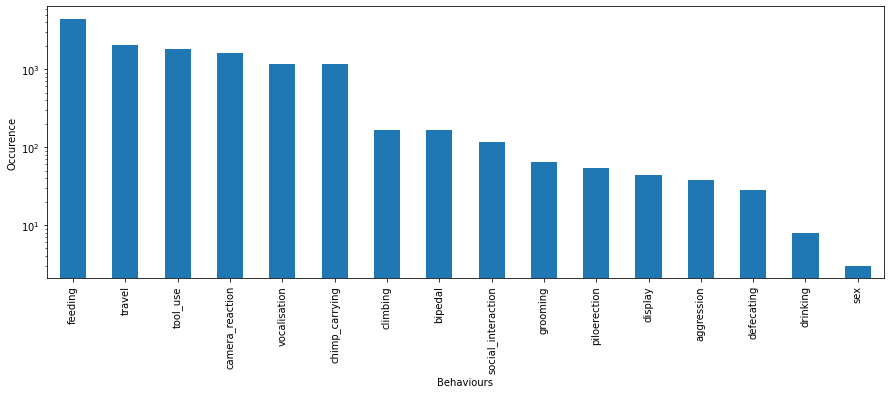

In [35]:
# Plot freq dist
attr = final_df.columns[6:]
counts=final_df[attr].sum(axis=0).sort_values(ascending=False) # occurence counts
ax = counts.plot.bar(figsize=(15,5), width=0.5);
plt.yscale('log');
ax.set_xlabel("Behaviours");
ax.set_ylabel("Occurence");
plt.savefig('foo.pdf')

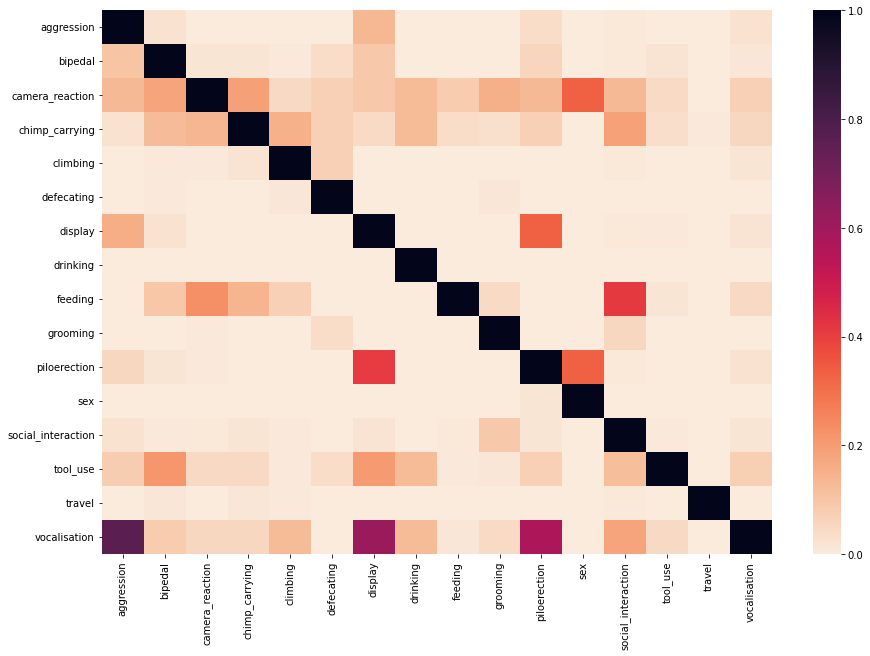

In [49]:
# Plot co-occurence matrix
coocc_df = final_df[attr].astype(int)
coocc = coocc_df.T.dot(coocc_df)

# Make sure it is relative for vis
diag = np.diag(coocc)
rel_co_matrix = np.array([1 / x for x in diag]) * coocc

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(rel_co_matrix, cmap="rocket_r");

In [33]:
# Apply the lambda function to each row to create a new column 'label'
final_df['label'] = final_df[final_df.columns[6:]].apply(to_label, axis=1).astype('category')
final_df['label'] = final_df.label.str.split(',')
final_df['label'] = final_df.label.apply(lambda x: str([int(i) for i in x]))

In [34]:
label_counts = pd.DataFrame(f.label.value_counts())
label_counts[label_counts.label>100].label.sum()

10463

In [43]:
final_df[final_df.video=='acp000aslr'].iloc[0]

video                 acp000aslr
tool_use_surface               0
tool_use_mound                 0
swelling                       0
night_chimps                   0
off_camera                     0
aggression                     0
bipedal                        0
camera_reaction                0
chimp_carrying                 1
climbing                       0
defecating                     0
display                        0
drinking                       0
feeding                        0
grooming                       0
piloerection                   0
sex                            0
social_interaction             0
tool_use                       0
travel                         0
vocalisation                   0
Name: 14132, dtype: object

**Generate train-test splits**

In [36]:
from skmultilearn.model_selection import iterative_train_test_split

In [37]:
X = final_df.video.to_numpy().reshape((11390,1))
labels = final_df[final_df.columns[6:-1]].to_numpy()

In [38]:
labels[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X, labels, test_size=0.30)

In [40]:
 # Train df
train_x_df = pd.DataFrame(X_train, columns=['video'])
train_y_df = pd.DataFrame(y_train, columns=final_df.columns[6:-1])
train_df = pd.concat([train_x_df, train_y_df], axis=1)

In [41]:
# Test df
test_x_df = pd.DataFrame(X_test, columns=['video'])
test_y_df = pd.DataFrame(y_test, columns=final_df.columns[6:-1])
test_df = pd.concat([test_x_df, test_y_df], axis=1)

In [42]:
for dataframe in [train_df, test_df]:
    dataframe['label'] = dataframe[dataframe.columns[1:]].apply(to_label, axis=1).astype('category')
    dataframe['label'] = dataframe.label.str.split(',')
    dataframe['label'] = dataframe.label.apply(lambda x: str([int(i) for i in x]))

In [43]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('val.csv', index=False)